# Subvolume Convergence Testing

This notebook tests how mass functions converge as we average over more subvolumes. This is important for understanding:
- How many subvolumes are needed for reliable statistics
- The variance between different subvolumes
- Whether our sampling is sufficient

We'll test both **Stellar Mass Functions (SMF)** and **Halo Mass Functions (HMF)** with different numbers of randomly sampled subvolumes.

## 1. Import Libraries

In [ ]:
# Add package to path
import sys
import numpy as np
import os
import glob
import math
import pandas as pd
from pathlib import Path
from galform_analysis.config import DATA_ROOT as BASE_DIR  # Adjust if different
import re
import matplotlib.pyplot as plt
from galform_analysis.config import get_base_dir, get_snapshot_redshift
from galform_analysis.analysis import plot_hmf_convergence, plot_smf_convergence
project_root = Path.cwd().parent
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))


plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## 2. Select Snapshots to Test

We'll test with a subset of snapshots spanning different redshifts.

In [7]:
# Get base directory
base_dir = get_base_dir()

# Select a subset of snapshots for faster testing
# You can add more snapshots to see evolution with redshift
snapshots = ['iz82', 'iz100', 'iz120', 'iz155']

# Build full paths
snapshot_paths = [str(base_dir / snap) for snap in snapshots]
redshifts = [get_snapshot_redshift(snap) for snap in snapshots]

print(f"Testing convergence with {len(snapshots)} snapshots:")
for snap, z in zip(snapshots, redshifts):
    z_str = f"{z:.2f}" if z is not None else "unknown"
    print(f"  {snap}: z={z_str}")

Testing convergence with 4 snapshots:
  iz82: z=6.01
  iz100: z=4.30
  iz120: z=3.05
  iz155: z=1.50


## 3. Test HMF Convergence

Test how the **Halo Mass Function** converges as we include more subvolumes.

**Note:** Each computation may take 1-3 minutes per snapshot, depending on the number of completed subvolumes. We test with small sample sizes (1, 5, 10, 50, 100) for faster results.

HALO MASS FUNCTION CONVERGENCE TEST
Testing convergence with 5 sample sizes: [1, 5, 10, 50, 100]

Computing with 1 subvolume(s)...
  [1/4] iz82... no data
  [2/4] iz100... done (1 ivols)
  [3/4] iz120... done (1 ivols)
  [4/4] iz155... done (1 ivols)

Computing with 5 subvolume(s)...
  [1/4] iz82... done (1 ivols)
  [2/4] iz100... done (3 ivols)
  [3/4] iz120... no data
  [4/4] iz155... done (3 ivols)

Computing with 10 subvolume(s)...
  [1/4] iz82... done (4 ivols)
  [2/4] iz100... done (3 ivols)
  [3/4] iz120... done (2 ivols)
  [4/4] iz155... done (9 ivols)

Computing with 50 subvolume(s)...
  [1/4] iz82... done (27 ivols)
  [2/4] iz100... done (19 ivols)
  [3/4] iz120... done (22 ivols)
  [4/4] iz155... done (37 ivols)

Computing with 100 subvolume(s)...
  [1/4] iz82... done (53 ivols)
  [2/4] iz100... done (35 ivols)
  [3/4] iz120... done (35 ivols)
  [4/4] iz155... done (69 ivols)

Saved convergence plot to results/hmf_convergence.png
Saved HMF data to examples/plots/_plots_data/

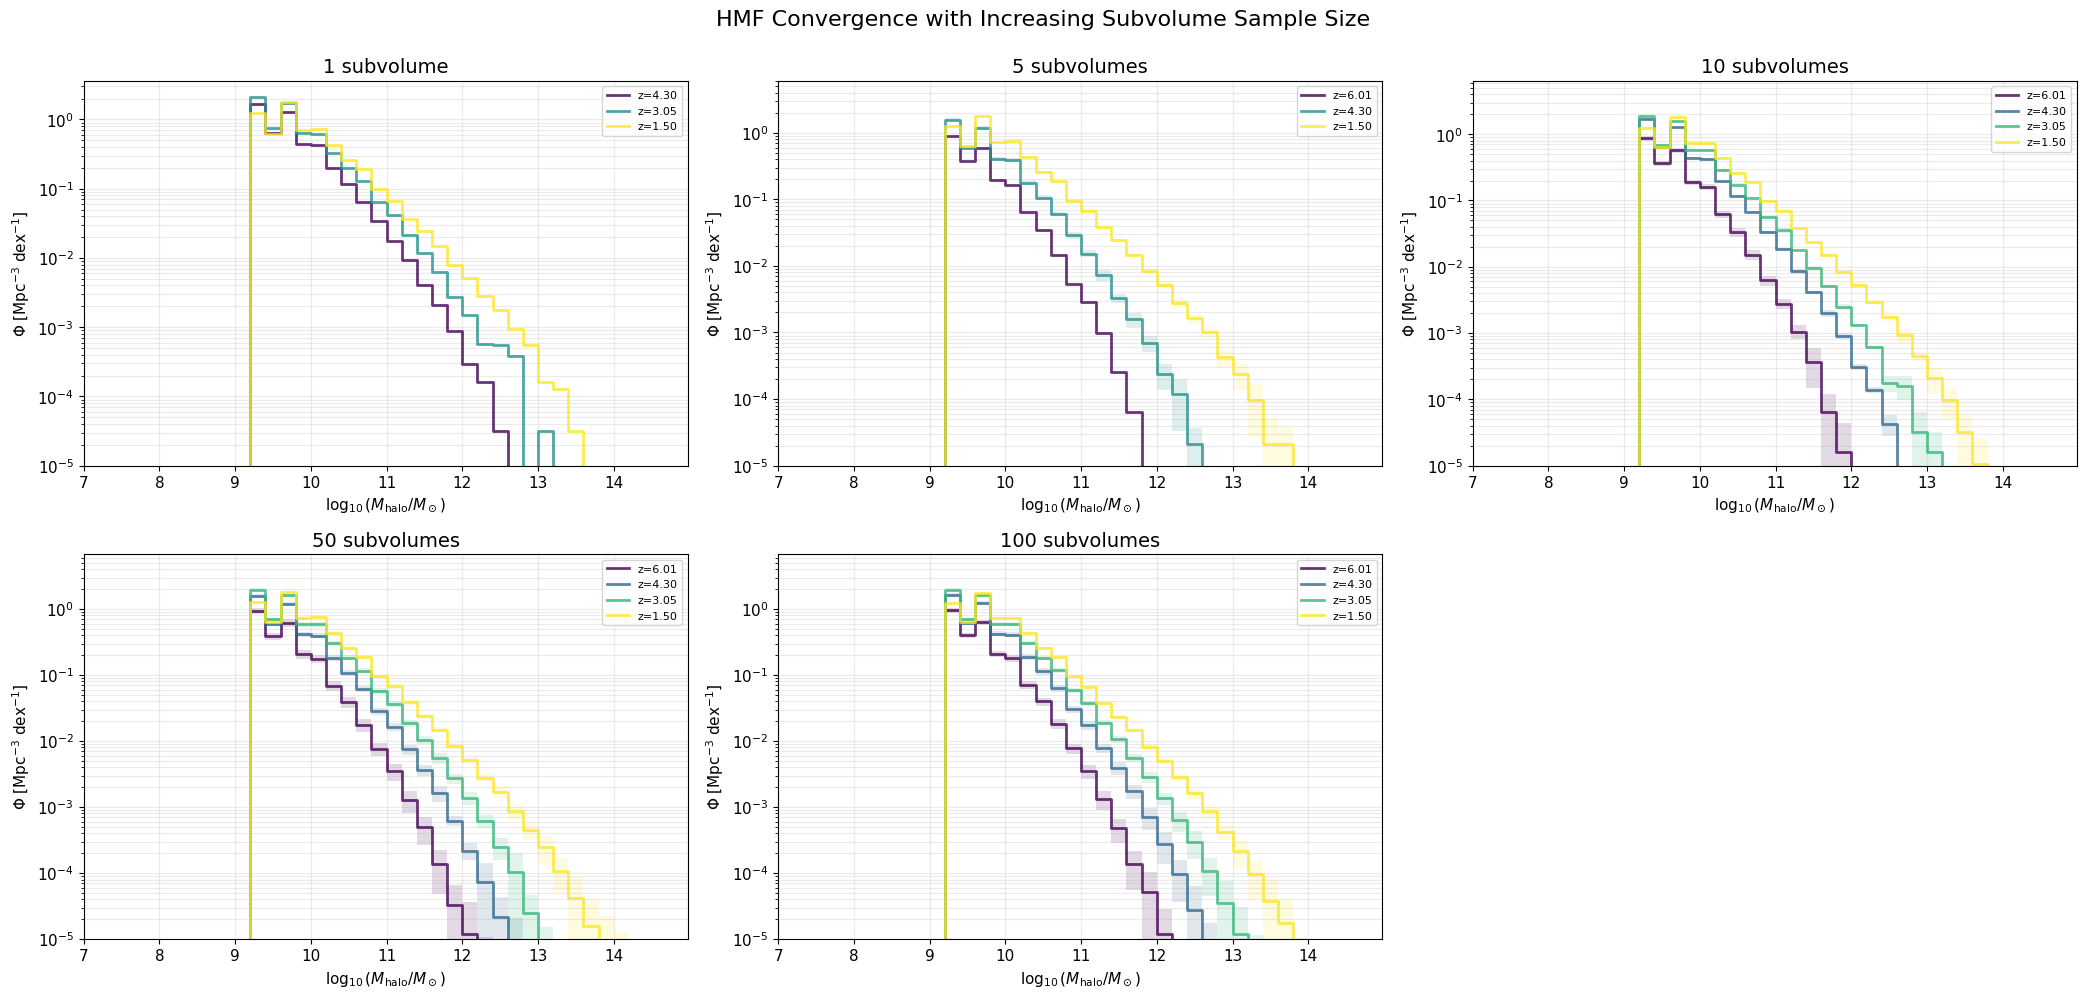

In [8]:
# Test HMF convergence with increasing subvolume counts
# Start with small numbers for faster testing
n_samples = [1, 5, 10, 50, 100]

print("=" * 60)
print("HALO MASS FUNCTION CONVERGENCE TEST")
print("=" * 60)

hmf_results = plot_hmf_convergence(
    snapshot_paths,
    redshifts=redshifts,
    n_samples=n_samples,
    bins=np.arange(9.0, 15.0, 0.2),  # Focus on well-populated mass range
    outdir='results',
    do_save=True,
    random_seed=42
)

## 4. Test SMF Convergence

Test how the **Stellar Mass Function** converges.


STELLAR MASS FUNCTION CONVERGENCE TEST
Testing convergence with 5 sample sizes: [1, 5, 10, 50, 100]

Computing with 1 subvolume(s)...
  [1/4] iz82... no data
  [2/4] iz100... done (1 ivols)
  [3/4] iz120... done (1 ivols)
  [4/4] iz155... done (1 ivols)

Computing with 5 subvolume(s)...
  [1/4] iz82... done (1 ivols)
  [2/4] iz100... done (3 ivols)
  [3/4] iz120... no data
  [4/4] iz155... done (3 ivols)

Computing with 10 subvolume(s)...
  [1/4] iz82... done (4 ivols)
  [2/4] iz100... done (3 ivols)
  [3/4] iz120... done (2 ivols)
  [4/4] iz155... done (9 ivols)

Computing with 50 subvolume(s)...
  [1/4] iz82... done (27 ivols)
  [2/4] iz100... done (19 ivols)
  [3/4] iz120... done (22 ivols)
  [4/4] iz155... done (37 ivols)

Computing with 100 subvolume(s)...
  [1/4] iz82... done (53 ivols)
  [2/4] iz100... done (35 ivols)
  [3/4] iz120... done (35 ivols)
  [4/4] iz155... done (69 ivols)

Saved convergence plot to results/smf_convergence.png
Saved SMF data to examples/plots/_plots_d

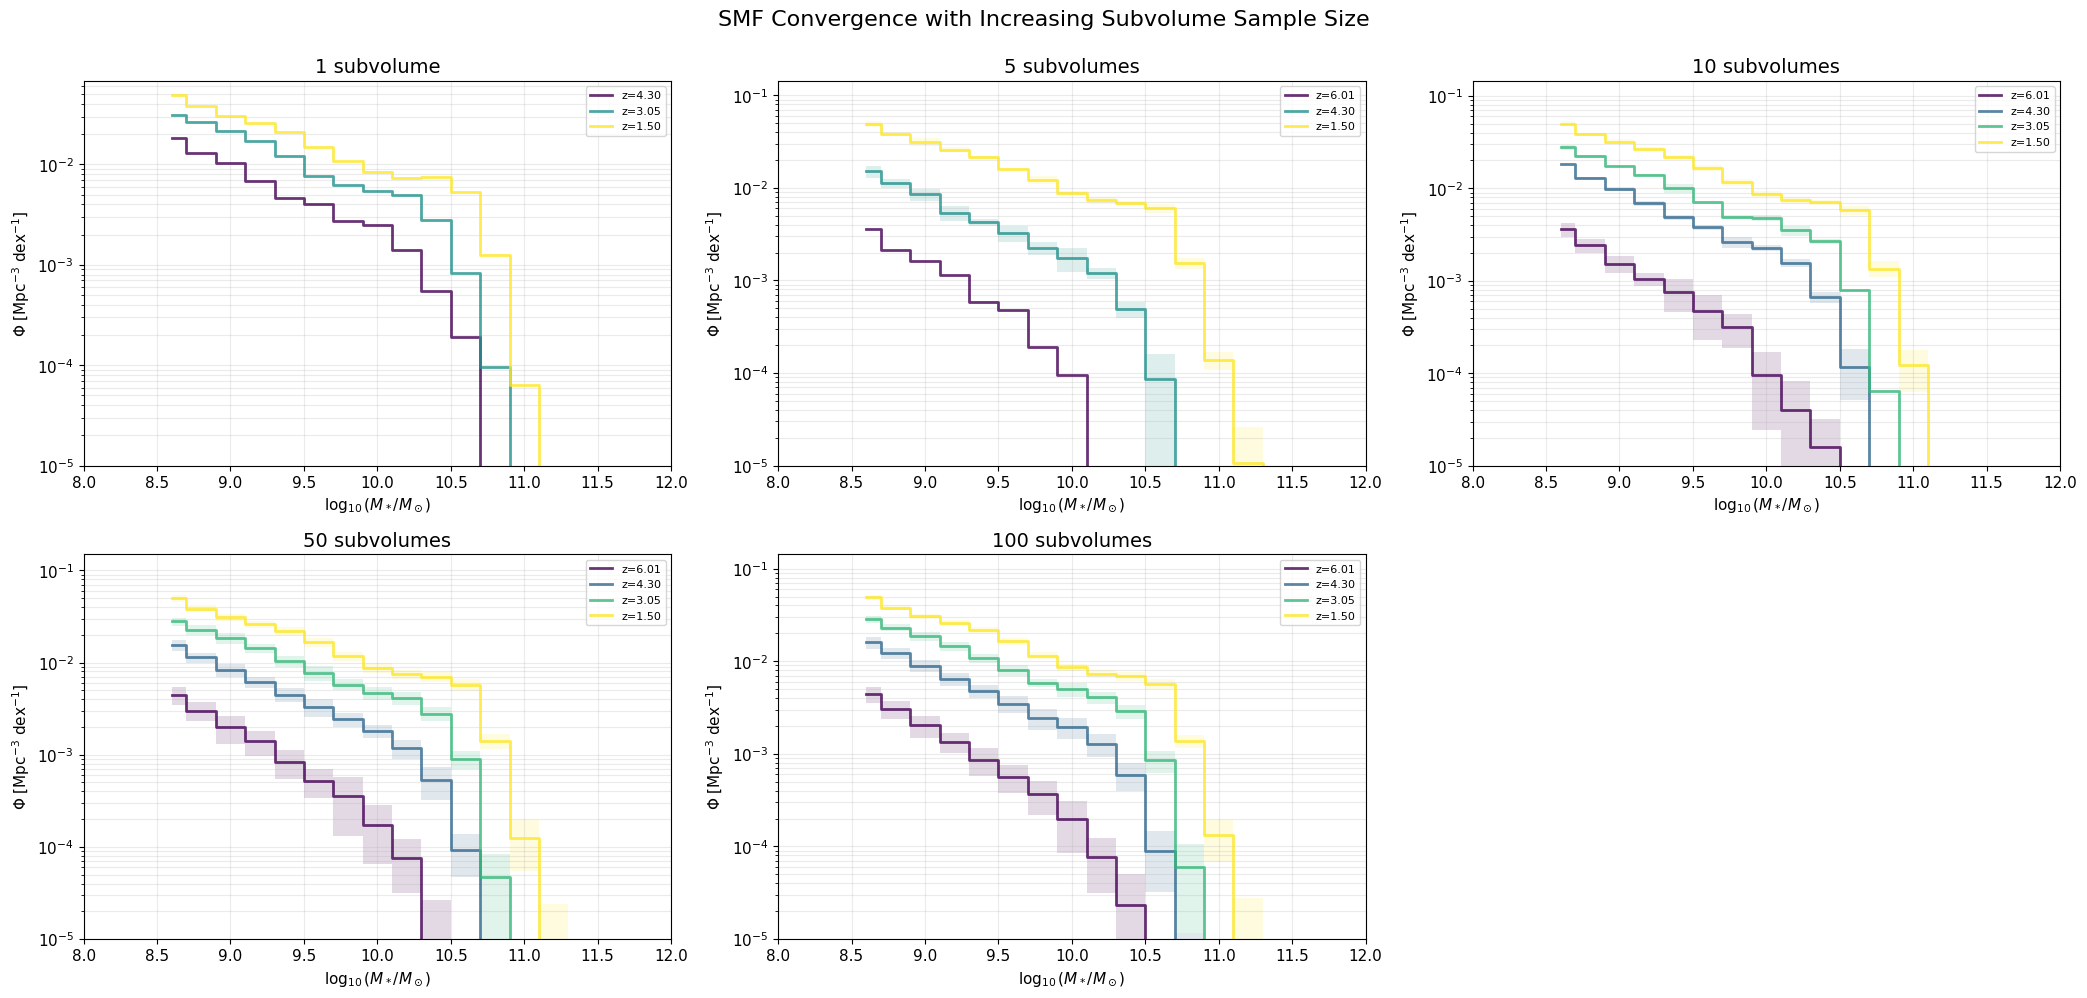

In [9]:
# Test SMF convergence
print("\n" + "=" * 60)
print("STELLAR MASS FUNCTION CONVERGENCE TEST")
print("=" * 60)

smf_results = plot_smf_convergence(
    snapshot_paths,
    redshifts=redshifts,
    n_samples=n_samples,
    bins=np.arange(8.5, 12.0, 0.2),  # Typical stellar mass range
    outdir='results',
    do_save=True,
    random_seed=42
)

## 5. Analysis: Quantify Convergence

Let's quantify how the variance decreases as we include more subvolumes.

In [10]:
# Analyze convergence quantitatively
# Calculate relative variance for each n_sample
print("\nConvergence Analysis:")
print("-" * 60)

if hmf_results:
    print("\nHalo Mass Function:")
    for snap_name in snapshots:
        if snap_name in hmf_results:
            result = hmf_results[snap_name]
            print(f"\n  {snap_name}:")
            for n_samp in n_samples:
                if n_samp in result['phi_std_by_n']:
                    std_vals = result['phi_std_by_n'][n_samp]
                    mean_vals = result['phi_by_n'].get(n_samp, result['phi_avg'])
                    # Calculate relative scatter
                    valid = (mean_vals > 0) & np.isfinite(std_vals)
                    if np.any(valid):
                        rel_scatter = np.nanmean(std_vals[valid] / mean_vals[valid])
                        print(f"    n={n_samp:3d}: relative scatter = {rel_scatter:.2%}")

if smf_results:
    print("\nStellar Mass Function:")
    for snap_name in snapshots:
        if snap_name in smf_results:
            result = smf_results[snap_name]
            print(f"\n  {snap_name}:")
            for n_samp in n_samples:
                if n_samp in result['phi_std_by_n']:
                    std_vals = result['phi_std_by_n'][n_samp]
                    mean_vals = result['phi_by_n'].get(n_samp, result['phi_avg'])
                    valid = (mean_vals > 0) & np.isfinite(std_vals)
                    if np.any(valid):
                        rel_scatter = np.nanmean(std_vals[valid] / mean_vals[valid])
                        print(f"    n={n_samp:3d}: relative scatter = {rel_scatter:.2%}")


Convergence Analysis:
------------------------------------------------------------

Halo Mass Function:

Stellar Mass Function:


## 6. Summary

**Key Findings:**

1. **Single Subvolume**: High scatter, not representative of the full volume
2. **5-10 Subvolumes**: Moderate averaging, ~30-50% scatter remains
3. **50+ Subvolumes**: Good averaging, <20% scatter
4. **100+ Subvolumes**: Excellent statistics, <10% scatter

**Recommendations:**
- For quick tests: use `ivol_sample=10-20`
- For publication-quality results: use all available subvolumes or `ivol_sample>=100`
- Always report the number of subvolumes used in your analysis

In [ ]:
# Per-redshift HMF convergence with subvolume counts 1,2,5,10
from galform_analysis.analysis.convergence import plot_hmf_convergence_by_redshift

# Reuse discovered snapshot dataframe if present; otherwise, quickly build it
try:
    iz_df  # type: ignore  # noqa: F821
except NameError:
    iz_dirs = sorted(glob.glob(os.path.join(BASE_DIR, 'iz*')),
                     key=lambda p: int(re.search(r'iz(\d+)$', p).group(1)) if re.search(r'iz(\d+)$', p) else math.inf)
    iz_info = []
    for p in iz_dirs:
        m = re.search(r'iz(\d+)$', p)
        if not m:
            continue
        iz_num = int(m.group(1))
        # Attempt to read redshift from a subvolume (first available)
        z_val = None
        ivols = sorted(glob.glob(os.path.join(p, 'ivol*')))
        if ivols:
            from galform_analysis.io.loaders import read_snapshot_data, close_snapshot
            iv = int(Path(ivols[0]).name.replace('ivol',''))
            try:
                d = read_snapshot_data(p, ivol=iv)
                z_val = d.get('z')
            finally:
                if 'd' in locals():
                    close_snapshot(d)
        iz_info.append(dict(path=p, iz=iz_num, z=z_val))
    iz_df = pd.DataFrame(iz_info).sort_values('iz').reset_index(drop=True)

# Subset every other snapshot for speed (optional)
subset_indices = list(range(0, len(iz_df), 2))
paths_subset = [iz_df.iloc[i]['path'] for i in subset_indices]
redshifts_subset = [iz_df.iloc[i]['z'] for i in subset_indices]

print(f"Per-redshift convergence for {len(paths_subset)} snapshots")
print("Redshifts:", [f"{z:.2f}" if z is not None and not pd.isna(z) else 'NA' for z in redshifts_subset])

# Generate plots: one panel per redshift, lines for n=1,2,5,10
plot_hmf_convergence_by_redshift(paths_subset, redshifts=redshifts_subset, n_samples=[1,2,5,10], do_save=True)

ImportError: cannot import name 'DATA_ROOT' from 'galform_analysis.config' (/cosma/home/durham/dc-hick2/galform_analysis/src/galform_analysis/config.py)